# Mask RCNN ResNet 50 (Blank Mask)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -q pycocotools

In [ ]:
import os
import json
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim

import torchvision
from torchvision import transforms as T
from torchvision.datasets.coco import CocoDetection
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval



In [ ]:
class COCOVehicleDataset(Dataset):
    def __init__(self, img_dir, ann_path, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms
        with open(ann_path) as f:
            self.coco = json.load(f)
        
        self.imgs = {img['id']: img for img in self.coco['images']}
        self.anns = {}
        for ann in self.coco['annotations']:
            img_id = ann['image_id']
            if img_id not in self.anns:
                self.anns[img_id] = []
            self.anns[img_id].append(ann)
        self.image_ids = list(self.imgs.keys())

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.imgs[img_id]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        boxes, labels, masks = [], [], []

        for ann in self.anns.get(img_id, []):
            bbox = ann['bbox']
            x, y, w, h = bbox
            boxes.append([x, y, x+w, y+h])
            labels.append(1)  
            rle_mask = cv2.imread(img_path, 0)  # dummy mask
            masks.append(torch.zeros((img.height, img.width), dtype=torch.uint8)) 

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.stack(masks)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([img_id])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)


## Model 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, 2) 
model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 227MB/s] 


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

## Data Load

In [6]:
import torchvision.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)


In [ ]:
train_dataset = COCOVehicleDataset(
    img_dir="/kaggle/input/traffic-dataset/traffic_wala_dataset/train/images",
    ann_path="/kaggle/input/coco-format/train_coco.json",
    transforms=get_transform(train=True)
)

val_dataset = COCOVehicleDataset(
    img_dir="/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images",
    ann_path="/kaggle/input/coco-format/val_coco.json",
    transforms=get_transform(train=False)
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


## Training

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 50


In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    batch_losses = []
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    for images, targets in tqdm(train_loader, desc="Training", leave=False):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        batch_losses.append(losses.item())
        total_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()


    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_loss:.4f}")



Epoch [1/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [1/50] - Avg Loss: 0.3422

Epoch [2/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [2/50] - Avg Loss: 0.2906

Epoch [3/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [3/50] - Avg Loss: 0.2584

Epoch [4/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [4/50] - Avg Loss: 0.2286

Epoch [5/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [5/50] - Avg Loss: 0.2090

Epoch [6/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [6/50] - Avg Loss: 0.1951

Epoch [7/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [7/50] - Avg Loss: 0.1755

Epoch [8/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [8/50] - Avg Loss: 0.1587

Epoch [9/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [9/50] - Avg Loss: 0.1479

Epoch [10/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [10/50] - Avg Loss: 0.1380

Epoch [11/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [11/50] - Avg Loss: 0.1290

Epoch [12/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [12/50] - Avg Loss: 0.1233

Epoch [13/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [13/50] - Avg Loss: 0.1167

Epoch [14/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [14/50] - Avg Loss: 0.1119

Epoch [15/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [15/50] - Avg Loss: 0.1070

Epoch [16/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [16/50] - Avg Loss: 0.1008

Epoch [17/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [17/50] - Avg Loss: 0.0965

Epoch [18/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [18/50] - Avg Loss: 0.0924

Epoch [19/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [19/50] - Avg Loss: 0.0889

Epoch [20/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [20/50] - Avg Loss: 0.0863

Epoch [21/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [21/50] - Avg Loss: 0.0856

Epoch [22/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [22/50] - Avg Loss: 0.0833

Epoch [23/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [23/50] - Avg Loss: 0.0801

Epoch [24/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [24/50] - Avg Loss: 0.0778

Epoch [25/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [25/50] - Avg Loss: 0.0798

Epoch [26/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [26/50] - Avg Loss: 0.0742

Epoch [27/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [27/50] - Avg Loss: 0.0763

Epoch [28/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [28/50] - Avg Loss: 0.0751

Epoch [29/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [29/50] - Avg Loss: 0.0805

Epoch [30/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [30/50] - Avg Loss: 0.0723

Epoch [31/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [31/50] - Avg Loss: 0.0681

Epoch [32/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [32/50] - Avg Loss: 0.0681

Epoch [33/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [33/50] - Avg Loss: 0.0731

Epoch [34/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [34/50] - Avg Loss: 0.0678

Epoch [35/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [35/50] - Avg Loss: 0.0639

Epoch [36/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [36/50] - Avg Loss: 0.0630

Epoch [37/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [37/50] - Avg Loss: 0.0650

Epoch [38/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [38/50] - Avg Loss: 0.0659

Epoch [39/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [39/50] - Avg Loss: 0.0711

Epoch [40/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [40/50] - Avg Loss: 0.0669

Epoch [41/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [41/50] - Avg Loss: 0.0611

Epoch [42/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [42/50] - Avg Loss: 0.0616

Epoch [43/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [43/50] - Avg Loss: 0.0616

Epoch [44/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [44/50] - Avg Loss: 0.0596

Epoch [45/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [45/50] - Avg Loss: 0.0647

Epoch [46/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [46/50] - Avg Loss: 0.0836

Epoch [47/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [47/50] - Avg Loss: 0.0689

Epoch [48/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [48/50] - Avg Loss: 0.0655

Epoch [49/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [49/50] - Avg Loss: 0.0634

Epoch [50/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [50/50] - Avg Loss: 0.0636


In [ ]:
torch.save(model.state_dict(), "maskrcnn_vehicle_detector.pth") #save model


## Evaluation

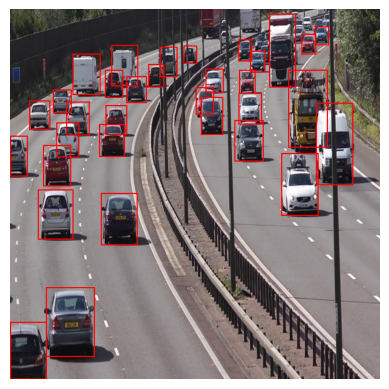

In [24]:
from PIL import ImageDraw

def infer_and_show(image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    image_draw = image.copy()
    draw = ImageDraw.Draw(image_draw)

    for box, score in zip(prediction["boxes"], prediction["scores"]):
        if score > 0.5:
            x1, y1, x2, y2 = box.cpu().numpy().astype(int)
            draw.rectangle(((x1, y1), (x2, y2)), outline="red", width=2)

    plt.imshow(image_draw)
    plt.axis("off")
    plt.show()

infer_and_show("/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images/10_mp4-25_jpg.rf.11c919cc683cc6a0d0a658be13483748.jpg")


In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)  

model.load_state_dict(torch.load("maskrcnn_vehicle_detector.pth"))
model.to(device)
model.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
def count_vehicles(image_path):
    from PIL import Image, ImageDraw
    import torchvision.transforms.functional as F

    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    vehicle_count = sum(score.item() > 0.5 for score in prediction['scores'])
    print(f"🚌 Detected {vehicle_count} vehicles in image: {os.path.basename(image_path)}")

    draw = ImageDraw.Draw(image)
    for box, score in zip(prediction['boxes'], prediction['scores']):
        if score > 0.5:
            x1, y1, x2, y2 = box.int().tolist()
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
    display(image)


🚌 Detected 4 vehicles in image: 6_mp4-14_jpg.rf.a5099c3eeb2c707a2193c0efa467bb2a.jpg


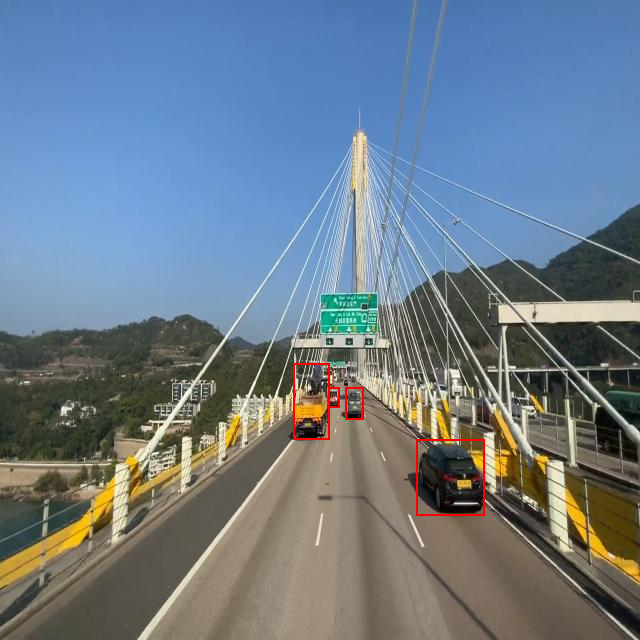

🚌 Detected 27 vehicles in image: 10_mp4-39_jpg.rf.af70092b5f2277f16d2703a4d59c3313.jpg


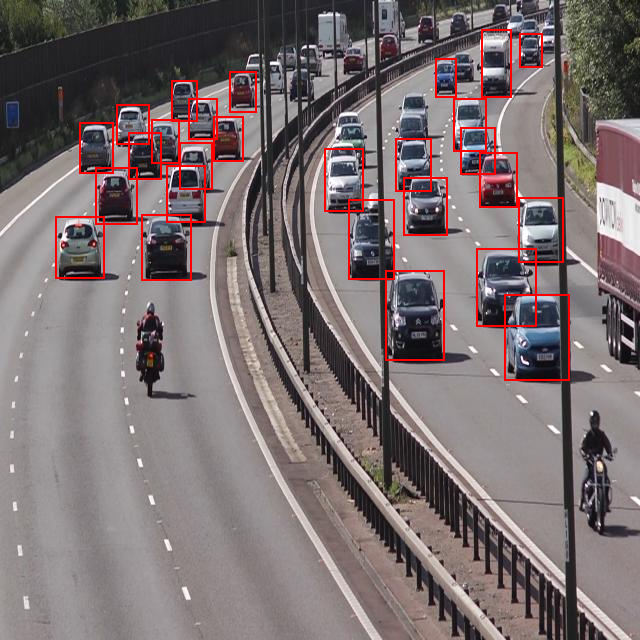

🚌 Detected 22 vehicles in image: 8_mp4-39_jpg.rf.bf01d183fca62e3316a0e4b31bfdf0da.jpg


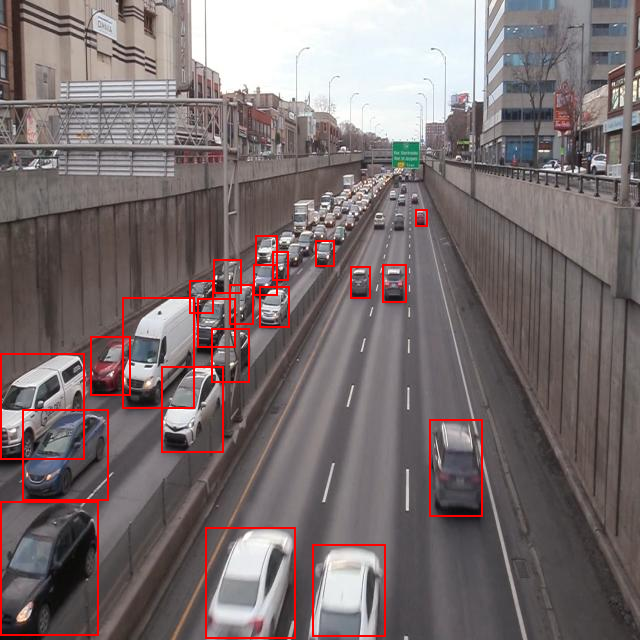

🚌 Detected 1 vehicles in image: 3_mp4-14_jpg.rf.6597c5732e0d554f1f07edb59abb4f8b.jpg


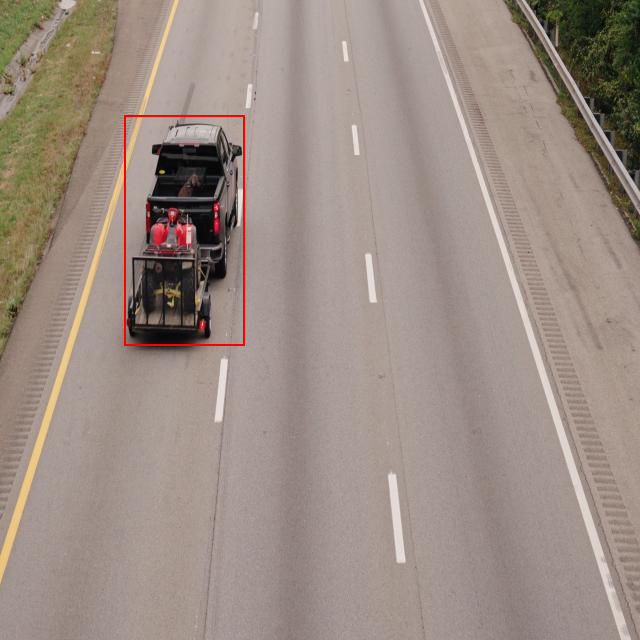

🚌 Detected 20 vehicles in image: test2_mp4-8_jpg.rf.c10dd559d44a868fd6f6877fd734815a.jpg


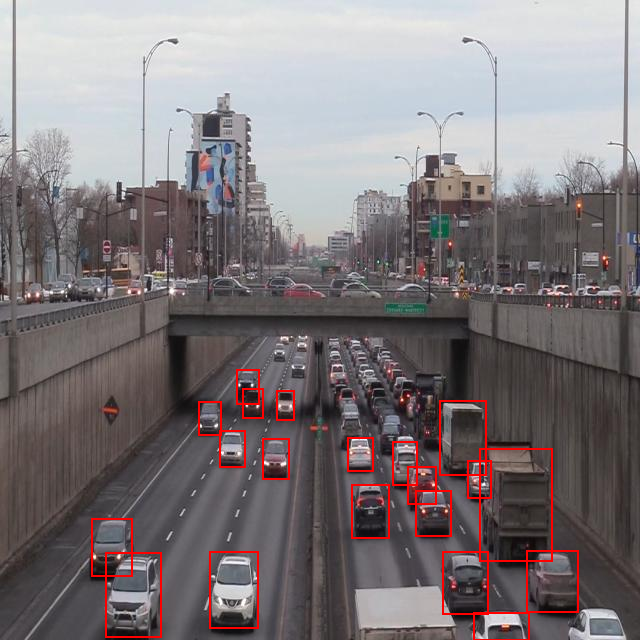

In [ ]:
import os
val_image_dir = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images"
for fname in os.listdir(val_image_dir)[20:25]: 
    count_vehicles(os.path.join(val_image_dir, fname))


## Metrics

In [ ]:
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH  = "/kaggle/input/maskrcnn/pytorch/default/1/maskrcnn_vehicle_detector.pth"
IMG_DIR     = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images"
ANN_PATH    = "/kaggle/input/coco-format/val_coco.json"
CONF_THRESH = 0.5

model = maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(DEVICE).eval()

coco_gt   = COCO(ANN_PATH)
img_ids   = coco_gt.getImgIds()
cat_ids   = coco_gt.getCatIds()
CAT_ID    = cat_ids[0]

to_tensor = T.ToTensor()
preds = []

for img_id in img_ids:
    info = coco_gt.loadImgs(img_id)[0]
    img_path = os.path.join(IMG_DIR, info["file_name"])
    img = Image.open(img_path).convert("RGB")
    tensor = to_tensor(img).to(DEVICE).unsqueeze(0)

    with torch.no_grad():
        out = model(tensor)[0]

    boxes  = out["boxes"].cpu().numpy()
    scores = out["scores"].cpu().numpy()

    for box, score in zip(boxes, scores):
        if score < CONF_THRESH:
            continue
        x1, y1, x2, y2 = box
        preds.append({
            "image_id":    img_id,
            "category_id": CAT_ID,
            "bbox":        [float(x1), float(y1), float(x2-x1), float(y2-y1)],
            "score":       float(score)
        })

with open("predictions.json", "w") as f:
    json.dump(preds, f)

coco_dt    = coco_gt.loadRes("predictions.json")
coco_eval  = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.669
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.941
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.848
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.822
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

## Video Testing

In [ ]:
import cv2
import torch
from torchvision import transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from deep_sort_realtime.deepsort_tracker import DeepSort

DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH  = "/kaggle/input/maskrcnn/pytorch/default/1/maskrcnn_vehicle_detector.pth"   
VIDEO_PATH    = "/kaggle/input/vidtryyy/56310-479197605_small.mp4"
OUTPUT_PATH   = "output_maskrcnn.mp4"
CONF_THRESH = 0.3

model = maskrcnn_resnet50_fpn(pretrained=False)
in_f = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_f, num_classes=2)  
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

cap = cv2.VideoCapture(VIDEO_PATH)
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_vid = cv2.VideoWriter(OUTPUT_PATH, fourcc, FPS, (W, H))

transform = T.ToTensor()
tracker = DeepSort(max_age=30)
PIXELS_PER_METER = 10
ROI_LINE_Y = int(0.6 * H)

entry_count = 0
exit_count = 0
object_last_centers = {}

# Main Loop 
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_tensor = transform(img_rgb).to(DEVICE).unsqueeze(0)

    with torch.no_grad():
        output = model(img_tensor)[0]

    detections = []
    for box, score in zip(output["boxes"], output["scores"]):
        if score >= CONF_THRESH:
            x1, y1, x2, y2 = box.int().tolist()
            w, h = x2 - x1, y2 - y1
            detections.append(([x1, y1, w, h], float(score), "vehicle"))

    tracks = tracker.update_tracks(detections, frame=frame)
    visible_vehicle_count = 0

    for track in tracks:
        if not track.is_confirmed():
            continue
        visible_vehicle_count += 1

        track_id = track.track_id
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2

        if track_id in object_last_centers:
            prev_cx, prev_cy = object_last_centers[track_id]
            if prev_cy < ROI_LINE_Y <= cy:
                entry_count += 1
            elif prev_cy > ROI_LINE_Y >= cy:
                exit_count += 1

            dist_px = np.hypot(cx - prev_cx, cy - prev_cy)
            speed = (dist_px * FPS) / PIXELS_PER_METER
        else:
            speed = 0

        object_last_centers[track_id] = (cx, cy)

       
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame, f"ID:{track_id} S:{speed:.1f}m/s", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

  
    cv2.line(frame, (0, ROI_LINE_Y), (W, ROI_LINE_Y), (255, 255, 0), 2)
    cv2.putText(frame, f"IN: {entry_count}  OUT: {exit_count}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
    cv2.putText(frame, f"Vehicles in Frame: {visible_vehicle_count}", (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    out_vid.write(frame)

cap.release()
out_vid.release()
print("✅ Saved: Tracked video with Live Vehicle Count")

## Thank You!